In [30]:
#! python2
# -*- coding: utf-8 -*-
import pprint
import pymongo
import datetime
import numpy as np
from pymongo import MongoClient

from scipy import spatial

import pylab

import os
import progressbar

db_name = 'twitter'
col_name = 'replab'

In [31]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity

from igraph import *
import igraph
import math
from operator import itemgetter



In [32]:
class MyPrettyPrinter(pprint.PrettyPrinter):
    def format(self, object, context, maxlevels, level):
        if isinstance(object, unicode):
            return (object.encode('thai'), True, False)
        return pprint.PrettyPrinter.format(self, object, context, maxlevels, level)

def go_print( input ):
    MyPrettyPrinter().pprint(input)
    # ppp = pprint.PrettyPrinter(indent=4)
    # ppp.pprint(input)
    return;

def get_midnight(time):
    return time.replace(minute=0, hour=0, second=0, microsecond=0)

def get_time_gap(time,hour_gap=1,min_gap=1):
    h = time.hour
    m = time.minute
    o_h = h/hour_gap*hour_gap
    o_m = m/min_gap*min_gap
    return time.replace(hour=o_h, minute=o_m, second=0, microsecond=0)

def get_week_year(time):
    return tuple([time.isocalendar()[0], time.isocalendar()[1]])

def get_thai_midnight(time):
    out = time + datetime.timedelta(hours=7)
    out = out.replace(minute=0, hour=0, second=0, microsecond=0) - datetime.timedelta(hours=7)
    return out

In [33]:
if __name__ == '__main__':
    client = MongoClient()
    db = client[db_name]

    result = db[col_name].create_index([('ts', pymongo.ASCENDING)])
    cursor = db[col_name].find({'ts':{'$gte':1338508800}}).sort([('ts', pymongo.ASCENDING)])
    

    entity = {}
    count = {}
    count_wk = {}
    
    topic_per_time = {}
    a_topic_per_time = {}

    bar = progressbar.ProgressBar(maxval=cursor.count()+1, widgets=[progressbar.Bar('#', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    data=1
    for doc in cursor:
        data += 1
        bar.update(data)
        
        ts = doc['ts']
        entity_id = doc['entity_id']
        topic = doc['topic']
        author = doc['author']
        datetime_object = datetime.datetime.fromtimestamp(ts)
        time_gap = get_midnight(datetime_object)
        
        if not entity.has_key(entity_id):
            entity[entity_id] = {}
        if not entity[entity_id].has_key(topic):
            entity[entity_id][topic] = {}
        if not time_gap in entity[entity_id][topic]:
            entity[entity_id][topic][time_gap] = 0
        entity[entity_id][topic][time_gap] += 1
        
        if not topic_per_time.has_key(time_gap):
            topic_per_time[time_gap] = {}
        if not topic_per_time[time_gap].has_key(topic):
             topic_per_time[time_gap][topic] = 0
        topic_per_time[time_gap][topic] += 1
        
        if not a_topic_per_time.has_key(time_gap):
            a_topic_per_time[time_gap] = {}
        if not a_topic_per_time[time_gap].has_key(topic):
             a_topic_per_time[time_gap][topic] = set()
                
        a_topic_per_time[time_gap][topic].add(author)
        
        time_gap = get_midnight(datetime_object) 
        if not count.has_key(time_gap):
            count[time_gap] = 0
        count[time_gap] += 1
        
        time_gap = get_week_year(datetime_object) 
        if not count_wk.has_key(time_gap):
            count_wk[time_gap] = 0
        count_wk[time_gap] += 1
        
        
        
    bar.finish()
#     print len(date)

[########################################################################] 100%


In [34]:
print 'avg per day\t: ',sum(count.values())/len(count)
print 'avg per week\t: ',sum(count_wk.values())/len(count_wk)

print 'max per day\t: ',max(count.values())
print 'max per week\t: ',max(count_wk.values())

avg per day	:  13
avg per week	:  64
max per day	:  193
max per week	:  501


In [35]:
test_data = []
for day, topic_count in topic_per_time.items():
    for v in topic_count.values():
        test_data.append(v)
    

test_data_a = []
for day, topic_count in a_topic_per_time.items():
    for v in topic_count.values():
        test_data_a.append(len(v))

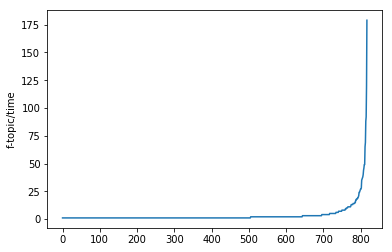

3
Counter({1: 505, 2: 139, 3: 52, 4: 21, 5: 17, 7: 9, 8: 9, 11: 8, 6: 7, 13: 5, 14: 5, 10: 4, 9: 3, 18: 3, 15: 2, 17: 2, 19: 2, 24: 2, 27: 2, 49: 2, 12: 1, 20: 1, 21: 1, 25: 1, 26: 1, 28: 1, 35: 1, 36: 1, 37: 1, 38: 1, 40: 1, 44: 1, 46: 1, 179: 1, 65: 1, 69: 1, 88: 1, 92: 1, 120: 1})


In [36]:
import matplotlib.pyplot as plt
plt.plot(sorted(test_data))
plt.ylabel('f-topic/time')
plt.show()
print (sum(test_data)/len(test_data))
from collections import Counter
print Counter(test_data)

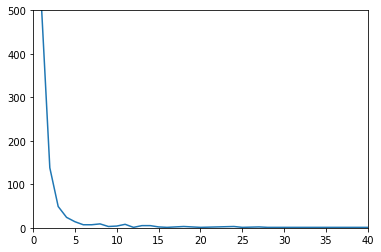

In [37]:
dt = Counter(test_data_a)
plt.plot(dt.keys(),dt.values())
plt.axis([0, 40, 0, 500])
plt.show()

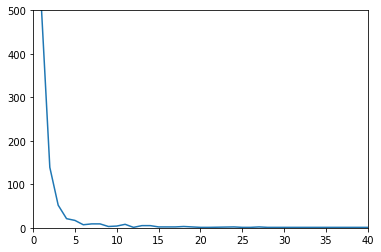

In [38]:
dt = Counter(test_data)
plt.plot(dt.keys(),dt.values())
plt.axis([0, 40, 0, 500])
plt.show()

In [39]:

ts = 1353459600
ts = 1349689576
datetime_o = datetime.datetime.fromtimestamp(ts)
print get_midnight(datetime_o)
for k,v in topic_per_time[get_midnight(datetime_o)].items():
    if v>=3:
        print k,v

2012-10-08 00:00:00


KeyError: datetime.datetime(2012, 10, 8, 0, 0)

In [12]:
for day,num in sorted(count.items() ):
    print day,num

2012-06-01 00:00:00 1079
2012-06-02 00:00:00 1754
2012-06-03 00:00:00 1398
2012-06-04 00:00:00 1406
2012-06-05 00:00:00 1307
2012-06-06 00:00:00 936
2012-06-07 00:00:00 768
2012-06-08 00:00:00 835
2012-06-09 00:00:00 725
2012-06-10 00:00:00 632
2012-06-11 00:00:00 599
2012-06-12 00:00:00 684
2012-06-13 00:00:00 701
2012-06-14 00:00:00 504
2012-06-15 00:00:00 405
2012-06-16 00:00:00 343
2012-06-17 00:00:00 306
2012-06-18 00:00:00 96
2012-06-19 00:00:00 299
2012-06-20 00:00:00 413
2012-06-21 00:00:00 403
2012-06-22 00:00:00 281
2012-06-23 00:00:00 90
2012-06-24 00:00:00 265
2012-06-25 00:00:00 257
2012-06-26 00:00:00 313
2012-06-27 00:00:00 344
2012-06-28 00:00:00 495
2012-06-29 00:00:00 315
2012-06-30 00:00:00 194
2012-07-01 00:00:00 175
2012-07-02 00:00:00 171
2012-07-03 00:00:00 146
2012-07-04 00:00:00 197
2012-07-05 00:00:00 130
2012-07-06 00:00:00 158
2012-07-07 00:00:00 95
2012-07-08 00:00:00 90
2012-07-09 00:00:00 115
2012-07-10 00:00:00 42
2012-07-11 00:00:00 99
2012-07-12 00:00:

In [13]:
for time,topic_set in sorted(topic_per_time.items()):
    print topic_set

{u'': 262, u'Workers': 2, u'Achievement - Sales': 2, u'Fans opinions about Dance Again': 2, u'Media Presence': 2, u'Theft': 2, u'Photos linked': 2, u'Favourites Rock Band': 2, u'Song/Lyrics Tweet': 20, u'Prize': 2, u'BMW parts and accesories for sale': 10, u'Compliments for Alicia Keys': 2, u'Song Payphone': 18, u'Surveys / Rankings results': 2, u'Jokes': 10, u'Electric BMW cars ': 2, u'Performance of Barclays': 2, u'Privacy of Britney Spears': 6, u'HSBC efficiency': 2, u'Fiat 500 sales ': 2, u'Bad Comments': 8, u"Fans Opinions about Goin'In": 2, u'Song Sharing': 6, u'Sale of accessories/complements/parts': 4, u'Toyota Prius': 4, u'I like Bon Jovi': 2, u'Toyota Hybrid': 2, u'Vehicle dealers': 4, u'Mentions inTwitter Users Conversations': 4, u'ReplaceSong game': 6, u'Swift': 2, u'Paris Balcony Concert': 4, u'Britney Spears\xb4 bad decisions': 2, u'For sale - Spare parts': 2, u'Volvo Ocean Race': 2, u'Comparisons': 6, u'Adele might set fire to the rain but SpongeBob can make a campfire u

In [14]:
for k,v in entity.items():
#     print k,len(v)
    print '\n\n\n++++++'
    for topic,time in v.items():
#         if len(time) > 5 and topic != '':
#         if topic != '':
        if sum(time.values()) > 10 and max(time.values()) >= 3 and topic != '':
            print topic,time.values()




++++++



++++++
Fan Defense [4, 1, 1, 1, 1, 3, 2, 1]
Pictures Related to the Beatles [2, 6, 4, 1, 3, 1, 1]
Video Music Tweet [11, 1, 12, 8, 2, 8, 11, 3, 6, 5, 3, 2, 6, 2, 4, 4, 13]
Fan Comments - Positive [9, 4, 8, 14, 4, 2, 4, 3, 8, 8, 10]
Pictures related to the Beatles - Fan related [5, 2, 4, 3, 2]
Mixed Product Comments [8, 2, 1, 3, 2]
#Bandsthatputmeinagoodmood [1, 12]
Comments by people who like the Beatles' music [2, 4, 6, 4, 3, 1, 2, 1, 5, 3, 3]
Other Topics [1, 2, 3, 4, 1]
Achievements [1, 8, 1, 1]
Sgt Pepper Album [4, 9]
Product Comparison [4, 1, 6, 2, 5, 12, 2, 1, 2, 2, 1, 5, 12, 1, 3, 8, 3]
Fan Comments [32, 15, 4, 7, 11]
Yoko Ono Blames Paul McCartney for Beatles 'Divorce' [1, 2, 10, 5, 1]
other topics [6, 6, 2, 3, 13, 2, 2, 2, 7, 7, 9, 3, 6, 3, 2]
Product Endorsement [2, 1, 6, 5, 15, 3, 9, 2, 10, 1, 14, 3, 1, 4, 1, 4, 9, 3]
Song/Lyrics Tweet [8, 13, 7, 16, 23, 10, 9, 1, 13, 2, 17, 6, 12, 8, 23, 20, 10]
Christmas & Fans [4, 1, 5, 4]
Now Playing /Listening - Beatles Mus

Vacancy  [1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 4, 4, 2, 1, 2, 1, 2, 1, 2, 1, 2, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1]
Cyberthieves & Hacking [3, 1, 1, 1, 1, 1, 2, 4, 1, 1]
Layoffs [3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1]
2nd Quarter Profit [1, 1, 13, 1]
Stock Ratings [1, 1, 2, 1, 1, 5, 1, 3, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1]
Mortgages [1, 1, 1, 1, 1, 3, 2, 1, 1, 2]
Unhappy Customers [1, 1, 1, 2, 1, 4, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Vacancy [1, 1, 5, 2, 1, 4, 1, 2, 1, 2, 1, 1, 1, 3, 2, 1, 2, 1]
Bofa Q3 [14, 2]
Bofa Stadium - Panthers [1, 1, 4, 1, 2, 2, 1, 1, 1, 3, 1, 3, 2, 1, 1, 4, 3, 1, 4]
Mortgage/Loan News [1, 2, 3, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1]
Other - Random Tweets [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 1]
Mortgage Fraud [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1]
Green Initiative [2, 1, 4, 1, 6, 1, 4]
Geotag / Checking In [1, 1, 2, 2, 1, 1, 4, 2, 2, 2

In [15]:
for k,v in entity.items():
#     print k,len(v)
    print '\n\n\n++++++'
    for topic,time in v.items():
#         if len(time) > 5 and topic != '':
#         if topic != '':
        if topic == "Gossip: JL and her kids":
            print time




++++++



++++++



++++++



++++++
{datetime.datetime(2012, 10, 9, 0, 0): 4, datetime.datetime(2012, 10, 2, 0, 0): 2, datetime.datetime(2012, 10, 8, 0, 0): 10, datetime.datetime(2012, 10, 5, 0, 0): 3, datetime.datetime(2012, 10, 4, 0, 0): 3, datetime.datetime(2012, 10, 3, 0, 0): 4}



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++



++++++
